# $k$-armed Bandit Problem

> You are faced repeatedly with a choice among
k di↵erent options, or actions. After each choice you receive a numerical reward chosen
from a stationary probability distribution that depends on the action you selected. Your
objective is to maximize the expected total reward over some time period, for example,
over 1000 action selections, or time steps.

You have a set of actions which provide stochastic rewards when taken. There is no "state" in the traditional RL problem sense. You merely have to evaluate and choose the best action as often as you can, while taking time to explore.

The _value_ of any action in this setup is the expected return of that action when taken.

$$
q_*(a) = \mathbb{E}[R_t \mid A_t = a ]
$$

The optimal action is the one for which $q_*(a)$ is highest. Selecting the action which currently has the highest estimated value is acting greedily, i.e _exploiting_ your knowledge rather than _exploring_ for new knowledge.

## Action Value methods

In action value methods, we form an estimate of the value of each action, $Q_t(a)$. The most natural way of doing this is to simply take the average reward for each action.

$$
Q_t(a) \quad \dot{=} \quad \frac{\sum_{i=1}^{t-1}{R_i \mathbb{1}_{A_i=a}}}{\sum_{i=1}^{t-1}{\mathbb{1}_{A_i=a}}}
$$

If we have never taken an action before, however, we use a default action value estimate, such as $0$.

Given our estimates, the greedy move is to always take the action $A_t = argmax_a{Q_t(a)}$. However, in order to explore to further refine our value estimates $Q_t(a)$, we can augment this somewhat by choosing the greedy action only with probability $1 - \epsilon, \epsilon > 0$. This is known as an $\epsilon$-greedy strategy. As the total number of actions that we can take approaches infinity, we will visit every action infinitely often, and so therefore:

$$
\lim{Q_t(a)} = q_*(a) = \mathbb{E}[R_t \mid A_t = a ]
$$

And so, eventually, we will always take the actually best action with $1-\epsilon$ probability.

_Exercise 2.1_
> In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon = 0.5$, what is the probability that the greedy action is selected?

Let $U \sim \mathcal{U}[0, 1]$.

$$
P(A_t = a_\mathrm{greedy}) = P(A_t = a_\mathrm{greedy} \mid U < \epsilon)P(U < \epsilon) + P(A_t = a_\mathrm{greedy} \mid U \ge \epsilon) P(U \ge \epsilon) \\
= \frac{1}{N}\epsilon + 1 (1-\epsilon) \\
= 1 - \frac{N-1}{N}\epsilon \\
= 1 - \frac{1}{2}0.5 = 0.75
$$

In [122]:
using Distributions
using Plots

function bandit_problem(k)
    mean_distribution = Normal(0, 1)
    means = rand(mean_distribution, k)
    return Normal.(means, 1)
end

problems = [ bandit_problem(10) for _ in 1:2000 ];

function ϵ_greedy(;k=10, ϵ=0.01)
    q_s = zeros(k)
    n_s = zeros(k)
    return function(dist)
        action = rand() < ϵ ? rand(1:k) : argmax(q_s ./ n_s)
        reward = dist(action)
        q_s[action] += reward
        n_s[action] += 1
        return reward, action
    end
end

ϵ_greedy (generic function with 1 method)

In [123]:
all_greedy_rewards = []
all_greedy_actions = []

all_greedy_01_rewards = []
all_greedy_01_actions = []

all_greedy_001_rewards = []
all_greedy_001_actions = []

for problem in problems
    dist(a) = rand(problem[a])
    greedy = ϵ_greedy(;k=10, ϵ=0.0)
    greedy_actions = []
    greedy_rewards = []

    greedy_01 = ϵ_greedy(;k=10, ϵ=0.1)
    greedy_01_actions = []
    greedy_01_rewards = []

    greedy_001 = ϵ_greedy(;k=10, ϵ=0.01)
    greedy_001_actions = []
    greedy_001_rewards = []
    for i in 1:1000
        r, a = greedy(dist)
        push!(greedy_rewards, r)
        push!(greedy_actions, a)

        r, a = greedy_01(dist)
        push!(greedy_01_rewards, r)
        push!(greedy_01_actions, a)

        r, a = greedy_001(dist)
        push!(greedy_001_rewards, r)
        push!(greedy_001_actions, a)
    end
    push!(all_greedy_rewards, greedy_rewards)
    push!(all_greedy_actions, greedy_actions)

    push!(all_greedy_01_rewards, greedy_01_rewards)
    push!(all_greedy_01_actions, greedy_01_actions)
    
    push!(all_greedy_001_rewards, greedy_001_rewards)
    push!(all_greedy_001_actions, greedy_001_actions)
end

In [124]:
greedy_reward_matrix = Float64.(reduce(hcat, all_greedy_rewards))
greedy_action_matrix = Int64.(reduce(hcat, all_greedy_actions))

greedy01_reward_matrix = Float64.(reduce(hcat, all_greedy_01_rewards))
greedy01_action_matrix = Int64.(reduce(hcat, all_greedy_01_actions))

greedy001_reward_matrix = Float64.(reduce(hcat, all_greedy_001_rewards))
greedy001_action_matrix = Int64.(reduce(hcat, all_greedy_001_actions));

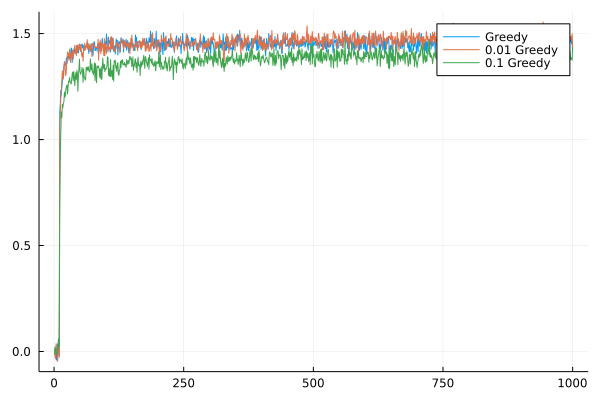

In [149]:
rewards_all = hcat(mean(greedy_reward_matrix, dims=2), mean(greedy001_reward_matrix, dims=2), mean(greedy01_reward_matrix, dims=2))
plot(rewards_all, label=["Greedy" "0.01 Greedy" "0.1 Greedy"])

In [145]:
optimal_actions = [ argmax([action.μ for action in problem]) for problem in problems]
optimal_action_matrix = repeat(optimal_actions', 1000);

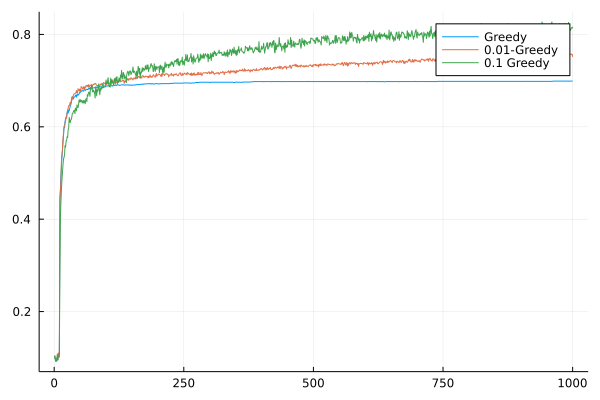

In [147]:
actions_all = hcat(
    mean(greedy_action_matrix .== repeat(optimal_actions', 1000), dims=2),
    mean(greedy001_action_matrix .== repeat(optimal_actions', 1000), dims=2),
    mean(greedy01_action_matrix .== repeat(optimal_actions', 1000), dims=2),
);

plot(actions_all, label=["Greedy" "0.01-Greedy" "0.1 Greedy"])